## Character-level LSTM Language Model
This notebook implements:
- LSTM architecture (i, f, o, g gates)
- Forward pass through time
- Backpropagation-through-time (BPTT)
- Training loop
- Text generation with temperature sampling

LSTM fixes the gradient problems of vanilla RNN and gives long memory.


In [50]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)


In [51]:
path = "data/alice.txt"
with open(path, "r", encoding="utf-8") as f:
    text = f.read().lower()

print("Characters:", len(text))
print(text[:300])


Characters: 148574
alice's adventures in wonderland

                alice's adventures in wonderland

                          lewis carroll

               the millennium fulcrum edition 3.0




                            chapter i

                      down the rabbit-hole


  alice was beginning to get very tir


In [52]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

char2idx = {ch:i for i,ch in enumerate(chars)}
idx2char = {i:ch for ch,i in char2idx.items()}

print("Vocab size:", vocab_size)


Vocab size: 46


In [53]:
data = np.array([char2idx[ch] for ch in text], dtype=np.int32)

split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]


LSTM cell computes:

i_t = σ(W_xi x_t + W_hi h_{t-1} + b_i)

f_t = σ(W_xf x_t + W_hf h_{t-1} + b_f)

o_t = σ(W_xo x_t + W_ho h_{t-1} + b_o)

g_t = tanh(W_xg x_t + W_hg h_{t-1} + b_g)

c_t = f_t * c_{t-1} + i_t * g_t

h_t = o_t * tanh(c_t)

Output:
y_t = W_hy h_t + b_y

p_t = softmax(y_t)



In [54]:
H = 256  # Match your RNN

def xavier(shape_in, shape_out):
    std = np.sqrt(2.0 / (shape_in + shape_out))
    return np.random.randn(shape_out, shape_in) * std

# Input gate
W_xi = xavier(vocab_size, H)
W_hi = xavier(H, H)
b_i  = np.zeros((H, 1))

# Forget gate - bias=1 is correct, keep this!
W_xf = xavier(vocab_size, H)
W_hf = xavier(H, H)
b_f = np.ones((H, 1))

# Output gate
W_xo = xavier(vocab_size, H)
W_ho = xavier(H, H)
b_o  = np.zeros((H, 1))

# Candidate gate
W_xg = xavier(vocab_size, H)
W_hg = xavier(H, H)
b_g  = np.zeros((H, 1))

# Output layer
W_hy = xavier(H, vocab_size)
b_y  = np.zeros((vocab_size, 1))

In [55]:
def softmax(v):
    e = np.exp(v - np.max(v))
    return e / np.sum(e)

def one_hot(idx, size):
    vec = np.zeros((size, 1))
    vec[idx] = 1.0
    return vec


In [56]:
def lstm_forward(inputs, targets, hprev, cprev):
    """
    inputs: list of integers
    """
    xs, hs, cs = {}, {}, {}
    is_, fs, os, gs = {}, {}, {}, {}
    ys, ps = {}, {}
    
    hs[-1] = hprev
    cs[-1] = cprev
    
    loss = 0
    
    for t in range(len(inputs)):
        xs[t] = one_hot(inputs[t], vocab_size)

        # Gates
        is_[t] = 1/(1+np.exp(-(W_xi@xs[t] + W_hi@hs[t-1] + b_i)))
        fs[t]  = 1/(1+np.exp(-(W_xf@xs[t] + W_hf@hs[t-1] + b_f)))
        os[t]  = 1/(1+np.exp(-(W_xo@xs[t] + W_ho@hs[t-1] + b_o)))
        gs[t]  = np.tanh(W_xg@xs[t] + W_hg@hs[t-1] + b_g)

        # Cell state
        cs[t] = fs[t] * cs[t-1] + is_[t] * gs[t]

        # Hidden
        hs[t] = os[t] * np.tanh(cs[t])

        # Output
        ys[t] = W_hy @ hs[t] + b_y
        ps[t] = softmax(ys[t])
        loss += -np.log(ps[t][targets[t], 0] + 1e-12)
    
    return loss, xs, hs, cs, is_, fs, os, gs, ps


In [57]:
def lstm_backward(inputs, targets, xs, hs, cs, is_, fs, os, gs, ps):
    # Create grads
    dW_xi = np.zeros_like(W_xi); dW_hi = np.zeros_like(W_hi); db_i = np.zeros_like(b_i)
    dW_xf = np.zeros_like(W_xf); dW_hf = np.zeros_like(W_hf); db_f = np.zeros_like(b_f)
    dW_xo = np.zeros_like(W_xo); dW_ho = np.zeros_like(W_ho); db_o = np.zeros_like(b_o)
    dW_xg = np.zeros_like(W_xg); dW_hg = np.zeros_like(W_hg); db_g = np.zeros_like(b_g)
    
    dW_hy = np.zeros_like(W_hy); db_y = np.zeros_like(b_y)
    
    dh_next = np.zeros((H,1))
    dc_next = np.zeros((H,1))

    T = len(inputs)
    for t in reversed(range(T)):
        dy = ps[t].copy()
        dy[targets[t]] -= 1
        dW_hy += dy @ hs[t].T
        db_y  += dy

        dh = W_hy.T @ dy + dh_next
        do = dh * np.tanh(cs[t])
        do_raw = os[t] * (1 - os[t])
        
        dc = dh * os[t] * (1 - np.tanh(cs[t])**2) + dc_next

        df = dc * cs[t-1]
        df_raw = fs[t] * (1 - fs[t])

        di = dc * gs[t]
        di_raw = is_[t] * (1 - is_[t])

        dg = dc * is_[t]
        dg_raw = (1 - gs[t]**2)

        # Params
        dW_xo += (do * do_raw) @ xs[t].T
        dW_ho += (do * do_raw) @ hs[t-1].T
        db_o  += (do * do_raw)

        dW_xf += (df * df_raw) @ xs[t].T
        dW_hf += (df * df_raw) @ hs[t-1].T
        db_f  += (df * df_raw)

        dW_xi += (di * di_raw) @ xs[t].T
        dW_hi += (di * di_raw) @ hs[t-1].T
        db_i  += (di * di_raw)

        dW_xg += (dg * dg_raw) @ xs[t].T
        dW_hg += (dg * dg_raw) @ hs[t-1].T
        db_g  += (dg * dg_raw)

        # Hidden + Cell backprop for next step
        dh_next = W_hi.T @ (di * di_raw) + \
                  W_hf.T @ (df * df_raw) + \
                  W_ho.T @ (do * do_raw) + \
                  W_hg.T @ (dg * dg_raw)

        dc_next = dc * fs[t]

    # Gradient clipping
    for grad in [dW_xi,dW_hi,db_i,dW_xf,dW_hf,db_f,
                 dW_xo,dW_ho,db_o,dW_xg,dW_hg,db_g,
                 dW_hy,db_y]:
        np.clip(grad, -5, 5, out=grad)


    return (dW_xi,dW_hi,db_i,
            dW_xf,dW_hf,db_f,
            dW_xo,dW_ho,db_o,
            dW_xg,dW_hg,db_g,
            dW_hy,db_y)


In [58]:
def update(params, grads, lr):
    for p, g in zip(params, grads):
        p -= lr * g


In [59]:
# Adam optimizer maps param -> (m, v)
adam_cache = {}

def adam_update(params, grads, lr, beta1=0.9, beta2=0.999, eps=1e-8):
    for i, (p, g) in enumerate(zip(params, grads)):
        if i not in adam_cache:
            adam_cache[i] = {
                "m": np.zeros_like(g),
                "v": np.zeros_like(g),
            }
        m = adam_cache[i]["m"]
        v = adam_cache[i]["v"]

        m[:] = beta1 * m + (1 - beta1) * g
        v[:] = beta2 * v + (1 - beta2) * (g * g)

        m_hat = m / (1 - beta1)
        v_hat = v / (1 - beta2)

        p -= lr * m_hat / (np.sqrt(v_hat) + eps)


In [60]:
def generate(seed, length=500, temperature=1.0):
    h = np.zeros((H,1))
    c = np.zeros((H,1))

    # Warmup
    for ch in seed[:-1]:
        if ch in char2idx:
            x = one_hot(char2idx[ch], vocab_size)
            i = 1/(1+np.exp(-(W_xi@x + W_hi@h + b_i)))
            f = 1/(1+np.exp(-(W_xf@x + W_hf@h + b_f)))
            o = 1/(1+np.exp(-(W_xo@x + W_ho@h + b_o)))
            g = np.tanh(W_xg@x + W_hg@h + b_g)
            c = f*c + i*g
            h = o * np.tanh(c)

    idx = char2idx[seed[-1]]
    output = seed

    for _ in range(length):
        x = one_hot(idx, vocab_size)
        i = 1/(1+np.exp(-(W_xi@x + W_hi@h + b_i)))
        f = 1/(1+np.exp(-(W_xf@x + W_hf@h + b_f)))
        o = 1/(1+np.exp(-(W_xo@x + W_ho@h + b_o)))
        g = np.tanh(W_xg@x + W_hg@h + b_g)
        c = f*c + i*g
        h = o * np.tanh(c)

        y = W_hy@h + b_y
        y = y / temperature
        p = softmax(y)
        idx = np.random.choice(range(vocab_size), p=p.ravel())
        output += idx2char[idx]

    return output


In [61]:
T = 50
lr = 1e-3
num_iterations = 100000

hprev = np.zeros((H, 1))
cprev = np.zeros((H, 1))
pointer = 0
smooth_loss = -np.log(1.0 / vocab_size) * T

loss_history = []

# Reset Adam cache for fresh training
adam_cache.clear()

for iteration in range(num_iterations):
    # Reset at end of data
    if pointer + T + 1 >= len(train_data):
        pointer = 0
        hprev = np.zeros((H, 1))
        cprev = np.zeros((H, 1))
    
    inputs = train_data[pointer : pointer + T]
    targets = train_data[pointer + 1 : pointer + T + 1]
    
    loss, xs, hs, cs, is_, fs, os, gs, ps = lstm_forward(inputs, targets, hprev, cprev)
    grads = lstm_backward(inputs, targets, xs, hs, cs, is_, fs, os, gs, ps)
    
    params = [W_xi, W_hi, b_i,
              W_xf, W_hf, b_f,
              W_xo, W_ho, b_o,
              W_xg, W_hg, b_g,
              W_hy, b_y]
    
    adam_update(params, grads, lr)
    
    # Carry hidden state forward
    hprev = hs[T - 1].copy()
    cprev = cs[T - 1].copy()
    pointer += T
    
    smooth_loss = 0.999 * smooth_loss + 0.001 * loss
    loss_history.append(smooth_loss)
    
    if iteration % 5000 == 0:
        print(f"Iter {iteration}, Loss: {smooth_loss:.4f}")
        print("Sample:", generate("alice ", length=100, temperature=0.7))
        print("-" * 50)

Iter 0, Loss: 191.4310
Sample: alice mc(3onmzpqj)n:'nv(eb`ays"up_,mi!
u33tr;(sk.*' ew0,,odyu(:-" ufr*cit'`uby't"cs'lf".rmfu)xf*
*j] !dx
*
--------------------------------------------------
Iter 5000, Loss: 102.0311
Sample: alice ner musrid abbuttor anca torwes
le a cheand so the much and you d the toes roe te tues tou tike.  `w
--------------------------------------------------
Iter 10000, Loss: 89.8212
Sample: alice jurting way fiedly hers has as she king see the queen it was houmd the groershing arohe she sho kear
--------------------------------------------------
Iter 15000, Loss: 82.3531
Sample: alice to hatterd!'

  `our here the rimloke to here weve seeped to his the hersered seenthen the drabbet a
--------------------------------------------------
Iter 20000, Loss: 77.5756
Sample: alice sare and go done she had see in a lood ene fint, and rame seat that at leas
    she hor soll the wis
--------------------------------------------------
Iter 25000, Loss: 73.1322
Sample: alice tur

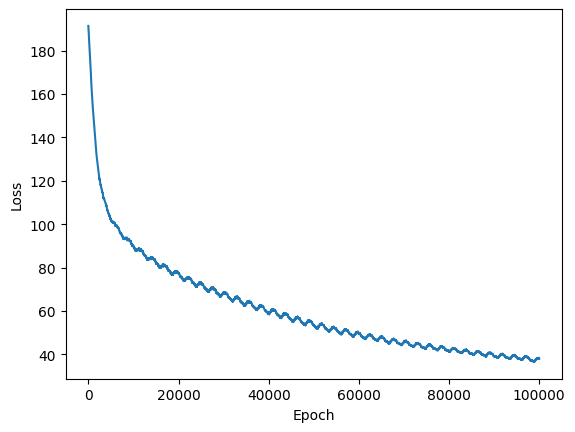

In [62]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


### Text Generation with LSTM 

In [82]:
print(generate("alice", 400, 0.4))



alice's advayy lead so macely, and
was as louged to reading to alice, and she said to hisself, `it manter was a minute,' alice
said to the way offenting her. `i mast go down, it's notured to alice!'

  `it is a leagled it,' said alice, `so a crush of you sole to lear his size, croquet?'       unid i'm a for oppersning again, and geen a little bread again:--i
thought at incat to the bottly nereved, `cra
